# Lesson2 畳み込みニューラルネットワーク (CNN)

## 目次

- Section1 解説
  - 1.1 CNN基礎
  - 1.2 Convolution(畳み込み)層
  - 1.3 Pooling(プーリング)層
  - 1.4 確認問題
- Section2 実装①
  - 2.1 Fasion MNISTをCNNでクラス分類
  - 2.2 CIFAR10のデータをCNNでクラス分類
- Section3 テクニック・発展内容
  - 3.1 Data Augmentation
  - 3.2 画像データの正規化
  - 3.3 Batch Normalization
  - 3.4 Skip Connection  (Residual Network)
  - 3.5 学習済みネットワークの利用
  - 3.6 学習させたモデルの保存・再利用
  - 3.7 確認問題
- Section4 実装②
  - 4.1 CIFAR10のデータをCNNでクラス分類②
- Section5 ケーススタディ

## 1.4の解答
問1: ①
問2: ①
問3: ①
問4: ①
問5: ①

In [1]:
%matplotlib inline

import os

import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

random_state = 42

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Section2 実装①

### 2.1 Fasion MNISTをCNNでクラス分類

まずは、Lesson1でも扱ったFashion MNISTのデータを今回はCNNを利用してクラス分類していきます。

#### 2.1.1 データセットの読み込み

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

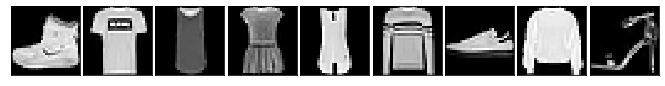

In [3]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap='gray')

このとき読み込んだ画像は(バッチサイズ、縦の画素数、 横の画素数)の次元で表されています。

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Lesson1の多層パーセプトロンでは入力を (バッチサイズ、画素数) の2次元テンソルとして扱いましたが、 CNNでは2次元の画像として処理していくために4次元テンソル (バッチサイズ、縦の画素数、横の画素数、チャンネル数)として扱います。 チャンネル数は白黒画像の場合は1、 カラー画像の場合はRGBで3です。

Fashion MNISTの画像は白黒データですのでチャンネル数を1に設定しています。(カラー画像の場合はチャンネル数が3になります)

In [8]:
x_train.shape

(60000, 28, 28, 1)

#### 2.1.2 実装

In [9]:
model = Sequential()

# 入力画像 28x28x1 (縦の画素数)x(横の画素数)x(チャンネル数)

# input size : (28,28,1)
# filter : 16
# filter size : (5,5)
# stride : (1,1)
# padding : (0,0)
# output size (24,24,16)
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(28, 28, 1)))  # 28x28x1 -> 24x24x16

# input size : (24,24,16)
# pooling size : (2,2)
# output size : (12,12,16)
model.add(MaxPooling2D(pool_size=(2, 2)))  # 24x24x16 -> 12x12x16

# input size : (12,12,16)
# filter : 64
# filter size : (5,5)
# stride : (1,1)
# padding : (0,0)
# output size (8,8,64)
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 12x12x16 -> 8x8x64

# input size : (8,8,64)
# pooling size : (2,2)
# output size : (4,4,64)
model.add(MaxPooling2D(pool_size=(2, 2)))  # 8x8x64 -> 4x4x64

# 全結合
model.add(Flatten())  # 4x4x64-> 1024
model.add(Dense(10, activation='softmax'))  # 1024 -> 10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.


作成したモデルを確認してみましょう。

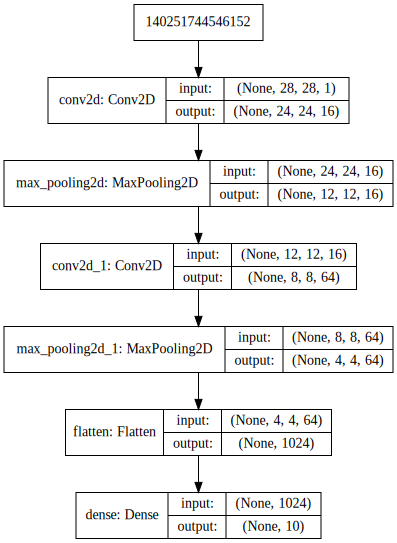

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
early_stopping = EarlyStopping(patience=1, verbose=1)
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=1,
          validation_data=(x_test, y_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
60000/60000 [==============================] - 11s 179us/sample - loss: 0.5368 - acc: 0.8091 - val_loss: 0.3944 - val_acc: 0.8594
Epoch 2/100
60000/60000 [==============================] - 10s 172us/sample - loss: 0.3510 - acc: 0.8749 - val_loss: 0.3696 - val_acc: 0.8668
Epoch 3/100
60000/60000 [==============================] - 11s 181us/sample - loss: 0.3075 - acc: 0.8910 - val_loss: 0.3199 - val_acc: 0.8846
Epoch 4/100
60000/60000 [==============================] - 12s 193us/sample - loss: 0.2776 - acc: 0.9006 - val_loss: 0.3055 - val_acc: 0.8918
Epoch 5/100
60000/60000 [==============================] - 10s 174us/sample - loss: 0.2570 - acc: 0.9081 - val_loss: 0.3011 - val_acc: 0.8912
Epoch 6/100
60000/60000 [==============================] - 10s 175us/sample - loss: 0.2392 - acc: 0.9126 - val_loss: 0.2943 - val_acc: 0.8946
Epoch 7/100
60000/60000 [=========================

### 2.2 CIFAR10のデータをCNNでクラス分類

####  2.2.1 データセットの読み込み

6万枚のカラー画像に10のカテゴリのどれかが付与されたCIFAR-10というデータセットを使用します。

まず、データを読み込みます。

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
y_train = np.eye(10)[y_train.astype('int32').flatten()]

x_test = x_test.astype('float32') / 255
y_test = np.eye(10)[y_test.astype('int32').flatten()]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

170500096/170498071 [==============================] - 15s 0us/step


画像はRGBデータなのでFashion MNISTとは異なり、チャンネル数は3になります。

In [13]:
x_train.shape

(40000, 32, 32, 3)

次に、CIFAR-10の画像の例を表示してみます。この画像ひとつひとつに10のカテゴリのうちひとつが付与されています。

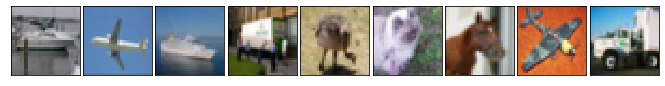

In [14]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

以下のネットワークを実装してみます。

![](./figures/lenet.png)

Y. LeCun et al., "Gradient-based learning applied to document recognition", Proceedings of the IEEE, 1998

#### 2.2.2 実装

In [17]:
model = Sequential()

# input size : (32,32,3)
# filter : 6
# filter size : (5,5)
# stride : (1,1)
# padding : (0,0)
# output size (28,28,6)
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(32, 32, 3)))  # 32x32x3 -> 28x28x6

# input size : (28,28,6)
# pooling size : (2,2)
# output size : (14,14,6)
model.add(MaxPooling2D(pool_size=(2, 2)))  # 28x28x6 -> 14x14x6

# input size : (14,14,6)
# filter : 16
# filter size : (5,5)
# stride : (1,1)
# padding : (0,0)
# output size (10,10,16)
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 14x14x6 -> 10x10x16

# input size : (10,10,16)
# pooling size : (2,2)
# output size : (5,5,6)
model.add(MaxPooling2D(pool_size=(2, 2)))  # 10x10x16 -> 5x5x16

# 全結合
model.add(Flatten())  # 5x5x16 -> 400
model.add(Dense(120, activation='relu',
                kernel_initializer='he_normal'))  # 400 ->120
model.add(Dense(84, activation='relu', kernel_initializer='he_normal'))  # 120 ->84
model.add(Dense(10, activation='softmax'))  # 84 ->10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

作成したモデルを確認してみましょう。

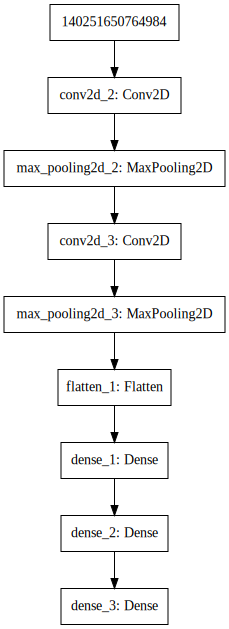

In [18]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [27]:
early_stopping = EarlyStopping(patience=5, verbose=1)
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 7s 183us/sample - loss: 0.7863 - acc: 0.7229 - val_loss: 1.1639 - val_acc: 0.6088
Epoch 2/100
40000/40000 [==============================] - 7s 184us/sample - loss: 0.7673 - acc: 0.7283 - val_loss: 1.1658 - val_acc: 0.6067
Epoch 3/100
40000/40000 [==============================] - 7s 184us/sample - loss: 0.7505 - acc: 0.7367 - val_loss: 1.2130 - val_acc: 0.6019
Epoch 4/100
40000/40000 [==============================] - 7s 184us/sample - loss: 0.7162 - acc: 0.7483 - val_loss: 1.2071 - val_acc: 0.6085
Epoch 5/100
40000/40000 [==============================] - 7s 184us/sample - loss: 0.7017 - acc: 0.7545 - val_loss: 1.2524 - val_acc: 0.6015
Epoch 6/100
40000/40000 [==============================] - 7s 184us/sample - loss: 0.6798 - acc: 0.7624 - val_loss: 1.2853 - val_acc: 0.5939
Epoch 00006: early stopping


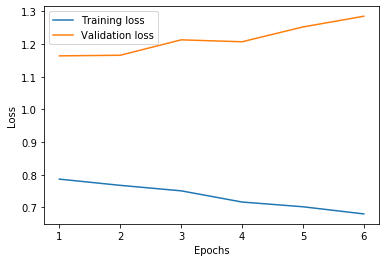

In [29]:
# ニューラルネットワークの分析
# 損失関数の履歴を取得
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]

# 損失関数をプロット
epochs=range(1,7)
plt.figure(facecolor="white")
plt.plot(epochs,loss_train,label="Training loss")
plt.plot(epochs,loss_val,label="Validation loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

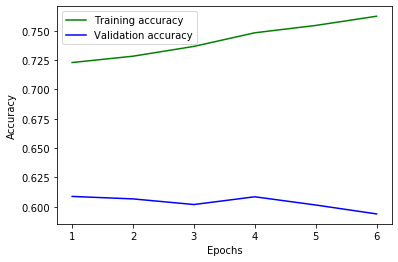

In [30]:
# 正解率を取得
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,7)
plt.figure(facecolor="white")
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()